In [1]:
%matplotlib inline
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

In [59]:
data = pd.read_csv('./data/low_temp_overall.csv')
data.head()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h",gas_feed molecular weight,"gas_feed Mass density, kg/m3","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed mass heat capacity,gas_feed Methane mass frac,gas_feed Ethane mass frac,...,"17 actual liquid flow, m3/h","17 actual vapour flow, m3/h",17 mass heat capacity,17 Methane mass frac,17 Ethane mass frac,17 Propane mass frac,17 i-Butane mass frac,17 n-Butane mass frac,17 i-Pentane mass frac,17 n-Pentane mass frac
0,-23.0,4041.0,21277.0,23.956971,73.393036,18.015246,271.889646,2.552841,0.508804,0.071252,...,16.473024,0.671735,2.248443,0.055855,0.065350,0.159964,0.362796,0.318673,0.009351,0.028012
1,-11.0,4320.0,6634.0,28.122865,103.408737,7.785243,56.367944,2.562291,0.358629,0.128836,...,7.471808,0.002190,3.172211,0.000006,0.092802,0.051350,0.424403,0.380461,0.026824,0.024153
2,9.0,4299.0,22552.0,27.218717,79.662664,20.458362,262.635360,2.574080,0.375699,0.151103,...,18.949131,0.423676,2.593380,0.022762,0.091335,0.049298,0.296327,0.511004,0.008935,0.020340
3,-15.0,4214.0,9679.0,23.387540,70.663424,6.863007,130.110260,2.640162,0.498093,0.158571,...,6.564201,0.000000,3.120212,0.000004,0.117264,0.232341,0.524567,0.045849,0.047009,0.032967
4,-15.0,3757.0,7193.0,19.586848,42.874012,1.841248,165.929382,2.504826,0.740581,0.022713,...,2.215091,0.131402,2.214229,0.048311,0.015410,0.058774,0.532420,0.216966,0.099379,0.028739


## Определение объемных расходов пара и жидкости сырьевого потока

In [3]:
feed_prod_vol_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

In [4]:
feed_prod_vol_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832


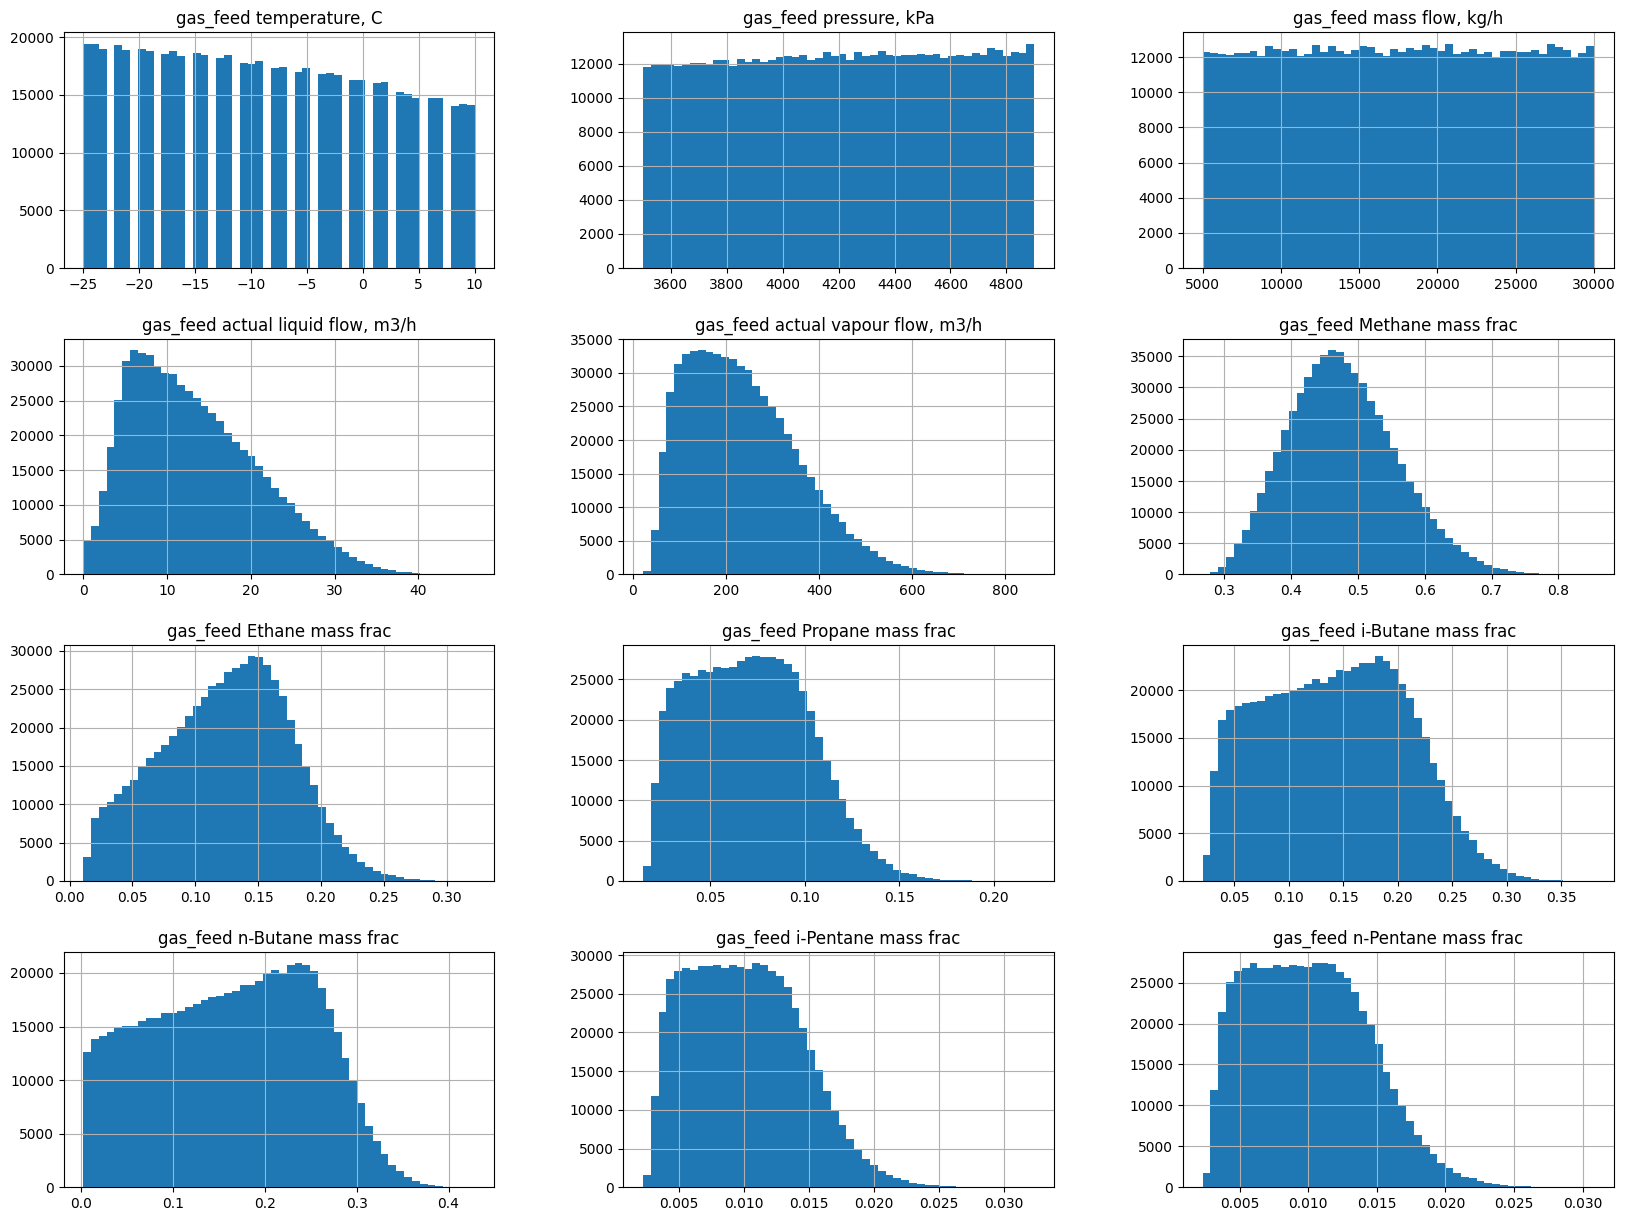

In [5]:
feed_prod_vol_flow.hist(bins=50, figsize=(20, 15));

In [6]:
corr_matrix = feed_prod_vol_flow.corr()

corr_matrix['gas_feed actual liquid flow, m3/h'].sort_values(ascending=False)

gas_feed actual liquid flow, m3/h    1.000000
gas_feed mass flow, kg/h             0.723261
gas_feed n-Butane mass frac          0.397954
gas_feed actual vapour flow, m3/h    0.225261
gas_feed i-Butane mass frac          0.214191
gas_feed pressure, kPa               0.093939
gas_feed Propane mass frac          -0.009964
gas_feed Ethane mass frac           -0.058984
gas_feed i-Pentane mass frac        -0.087376
gas_feed n-Pentane mass frac        -0.090083
gas_feed temperature, C             -0.238838
gas_feed Methane mass frac          -0.548213
Name: gas_feed actual liquid flow, m3/h, dtype: float64

In [7]:
## Тестовая и обучающая выборки
X = feed_prod_vol_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
]]

y = feed_prod_vol_flow[[
    'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed Methane mass frac',
    'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac','gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 10), (494360, 2))

In [8]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
feed_prod_vol_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(2)
])

# 2. Compile the model
feed_prod_vol_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
feed_prod_vol_flow_model.fit(X_train_normal, y_train, epochs=40)

Epoch 1/40
15449/15449 [==============================] - 31s 2ms/step - loss: 2.2094 - mae: 2.2094
Epoch 2/40
15449/15449 [==============================] - 33s 2ms/step - loss: 0.9969 - mae: 0.9969
Epoch 3/40
15449/15449 [==============================] - 32s 2ms/step - loss: 0.8725 - mae: 0.8725
Epoch 4/40
15449/15449 [==============================] - 50s 3ms/step - loss: 0.7854 - mae: 0.7854
Epoch 5/40
15449/15449 [==============================] - 39s 2ms/step - loss: 0.7297 - mae: 0.7297
Epoch 6/40
15449/15449 [==============================] - 34s 2ms/step - loss: 0.6990 - mae: 0.6990
Epoch 7/40
15449/15449 [==============================] - 34s 2ms/step - loss: 0.6505 - mae: 0.6505
Epoch 8/40
15449/15449 [==============================] - 33s 2ms/step - loss: 0.6296 - mae: 0.6296
Epoch 9/40
15449/15449 [==============================] - 36s 2ms/step - loss: 0.5921 - mae: 0.5921
Epoch 10/40
15449/15449 [==============================] - 41s 3ms/step - loss: 0.5677 - mae: 0.5677

In [9]:
y_pred = feed_prod_vol_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 1ms/step


In [10]:
x = 156
pred = y_pred[x]
pred

array([  6.8597426, 349.4037   ], dtype=float32)

In [11]:
test = y_test.iloc[x]
test

gas_feed actual liquid flow, m3/h      6.926595
gas_feed actual vapour flow, m3/h    348.885917
Name: 30381, dtype: float64

In [13]:
feed_prod_vol_flow_model.save('./models/low_temp_dist_24_04/feed_prod_vol_flow_model.h5')

## Определение массовых расходов продуктов сепаратора

In [15]:
sep_prod_mass_flow = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    '1 mass flow, kg/h', '2 mass flow, kg/h'
]]

In [16]:
sep_prod_mass_flow.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,gas_feed i-Pentane mass frac,gas_feed n-Pentane mass frac,"1 mass flow, kg/h","2 mass flow, kg/h"
count,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000,617950.000000
mean,-8.480579,4207.666418,17513.410166,13.334570,236.913322,0.477853,0.123608,0.071424,0.143099,0.163792,0.010122,0.010102,10708.440240,6804.969926
std,10.266356,403.397921,7206.613928,7.586198,119.499390,0.080848,0.050958,0.030397,0.064333,0.086969,0.004279,0.004274,5156.225297,3873.795315
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,0.002234,0.002290,1178.371232,0.000000
25%,-17.000000,3860.000000,11290.000000,7.247971,141.562427,0.419732,0.086266,0.046392,0.089873,0.091571,0.006606,0.006578,6520.828264,3691.914667
50%,-9.000000,4211.000000,17518.000000,12.151037,220.801211,0.472422,0.126887,0.070418,0.143815,0.168010,0.009864,0.009854,10148.332833,6192.395464
75%,0.000000,4557.000000,23750.000000,18.383058,313.726759,0.530387,0.160727,0.093634,0.192630,0.235017,0.013161,0.013138,14193.118168,9389.228804
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.379844,0.428366,0.032362,0.030832,29970.000000,23148.669181


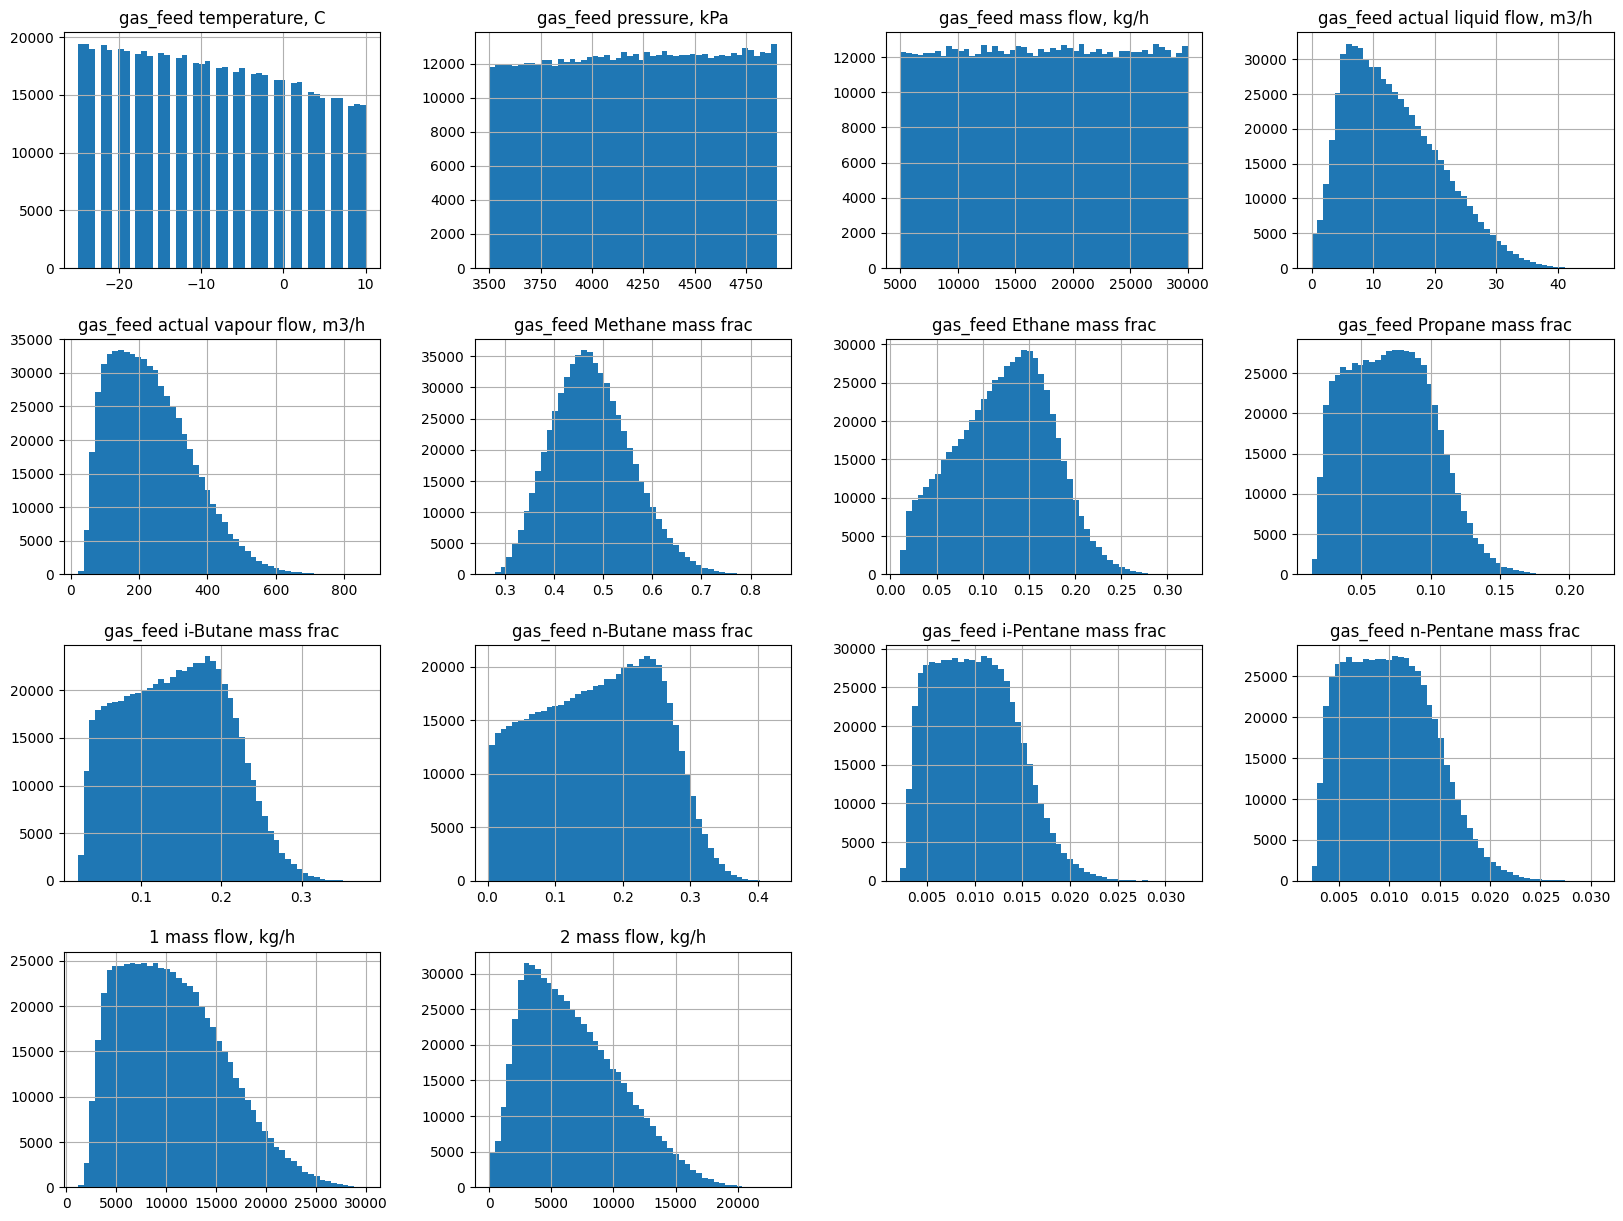

In [17]:
sep_prod_mass_flow.hist(bins=50, figsize=(20, 15));

In [18]:
corr_matrix = sep_prod_mass_flow.corr()

corr_matrix['1 mass flow, kg/h'].sort_values(ascending=False)

1 mass flow, kg/h                    1.000000
gas_feed actual vapour flow, m3/h    0.964563
gas_feed mass flow, kg/h             0.854649
gas_feed Methane mass frac           0.404069
gas_feed actual liquid flow, m3/h    0.260942
2 mass flow, kg/h                    0.258893
gas_feed temperature, C              0.187186
gas_feed Ethane mass frac            0.072754
gas_feed i-Pentane mass frac         0.064500
gas_feed n-Pentane mass frac         0.061846
gas_feed Propane mass frac           0.015669
gas_feed pressure, kPa              -0.045402
gas_feed i-Butane mass frac         -0.155920
gas_feed n-Butane mass frac         -0.314609
Name: 1 mass flow, kg/h, dtype: float64

In [28]:
## Тестовая и обучающая выборки
X = sep_prod_mass_flow[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
]]

y = sep_prod_mass_flow[['1 mass flow, kg/h']]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((494360, 12), (494360, 1))

In [29]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_prod_mass_flow_model = tf.keras.Sequential([
    tf.keras.layers.Dense(12, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(1)
])

# 2. Compile the model
sep_prod_mass_flow_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_prod_mass_flow_model.fit(X_train_normal, y_train, epochs=50)

Epoch 1/50
15449/15449 [==============================] - 24s 2ms/step - loss: 288.8892 - mae: 288.8892
Epoch 2/50
15449/15449 [==============================] - 23s 2ms/step - loss: 53.8112 - mae: 53.8112
Epoch 3/50
15449/15449 [==============================] - 25s 2ms/step - loss: 41.1446 - mae: 41.1446
Epoch 4/50
15449/15449 [==============================] - 25s 2ms/step - loss: 34.6084 - mae: 34.6084
Epoch 5/50
15449/15449 [==============================] - 25s 2ms/step - loss: 31.2063 - mae: 31.2063
Epoch 6/50
15449/15449 [==============================] - 25s 2ms/step - loss: 29.9441 - mae: 29.9441
Epoch 7/50
15449/15449 [==============================] - 26s 2ms/step - loss: 29.0855 - mae: 29.0855
Epoch 8/50
15449/15449 [==============================] - 26s 2ms/step - loss: 28.4967 - mae: 28.4967
Epoch 9/50
15449/15449 [==============================] - 28s 2ms/step - loss: 28.0549 - mae: 28.0549
Epoch 10/50
15449/15449 [==============================] - 30s 2ms/step - loss: 

In [30]:
y_pred = sep_prod_mass_flow_model.predict(X_test_normal)

3863/3863 [==============================] - 5s 1ms/step


In [39]:
x = 678
pred = y_pred[x]
pred

array([16290.109], dtype=float32)

In [40]:
test = y_test.iloc[x]
test

1 mass flow, kg/h    16269.813575
Name: 526689, dtype: float64

In [41]:
sum(pred)

16290.109375

In [43]:
sep_prod_mass_flow_model.save('./models/low_temp_dist_24_04/sep_prod_mass_flow_model.h5')

## Определение состава продуктов сепаратора

In [60]:
sep_prod_comp = data[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h', '1 Methane mass frac', '1 Ethane mass frac',
    '1 Propane mass frac', '1 i-Butane mass frac', '1 n-Butane mass frac', '1 i-Pentane mass frac',
    '1 n-Pentane mass frac',
]]

In [61]:
## Рассчитываем массовые расходы отдельных компонентов
sep_prod_comp.loc[:, 'gas_feed Methane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed Methane mass frac']
sep_prod_comp.loc[:, 'gas_feed Ethane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed Ethane mass frac']
sep_prod_comp.loc[:, 'gas_feed Propane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed Propane mass frac']
sep_prod_comp.loc[:, 'gas_feed i-Butane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed i-Butane mass frac']
sep_prod_comp.loc[:, 'gas_feed n-Butane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed n-Butane mass frac']
sep_prod_comp.loc[:, 'gas_feed i-Pentane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed i-Pentane mass frac']
sep_prod_comp.loc[:, 'gas_feed n-Pentane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed n-Pentane mass frac']

sep_prod_comp.loc[:, '1 Methane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 Methane mass frac']
sep_prod_comp.loc[:, '1 Ethane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 Ethane mass frac']
sep_prod_comp.loc[:, '1 Propane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 Propane mass frac']
sep_prod_comp.loc[:, '1 i-Butane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 i-Butane mass frac']
sep_prod_comp.loc[:, '1 n-Butane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 n-Butane mass frac']
sep_prod_comp.loc[:, '1 i-Pentane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 i-Pentane mass frac']
sep_prod_comp.loc[:, '1 n-Pentane mass flow, kg/h'] = sep_prod_comp['1 mass flow, kg/h'] * sep_prod_comp['1 n-Pentane mass frac']

C:\Users\79279\AppData\Local\Temp\ipykernel_16716\2680377508.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_prod_comp.loc[:, 'gas_feed Methane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed Methane mass frac']
C:\Users\79279\AppData\Local\Temp\ipykernel_16716\2680377508.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sep_prod_comp.loc[:, 'gas_feed Ethane mass flow, kg/h'] = sep_prod_comp['gas_feed mass flow, kg/h'] * sep_prod_comp['gas_feed Ethane mass f

In [62]:
# sep_prod_comp_sample = sep_prod_comp.sample(frac=0.7)

In [63]:
sep_prod_comp_sample.describe()

,"gas_feed temperature, C","gas_feed pressure, kPa","gas_feed mass flow, kg/h","gas_feed actual liquid flow, m3/h","gas_feed actual vapour flow, m3/h",gas_feed Methane mass frac,gas_feed Ethane mass frac,gas_feed Propane mass frac,gas_feed i-Butane mass frac,gas_feed n-Butane mass frac,...,"gas_feed n-Butane mass flow, kg/h","gas_feed i-Pentane mass flow, kg/h","gas_feed n-Pentane mass flow, kg/h","1 Methane mass flow, kg/h","1 Ethane mass flow, kg/h","1 Propane mass flow, kg/h","1 i-Butane mass flow, kg/h","1 n-Butane mass flow, kg/h","1 i-Pentane mass flow, kg/h","1 n-Pentane mass flow, kg/h"
count,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,...,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000,432565.000000
mean,-8.470734,4208.117277,17510.778366,13.333709,236.842373,0.477824,0.123636,0.071466,0.143128,0.163715,...,2866.314844,177.352910,176.739359,7630.061509,1460.317320,517.814774,589.451167,471.471766,20.763032,16.685050
std,10.271702,403.385928,7208.436824,7.590188,119.500106,0.080937,0.050939,0.030384,0.064298,0.086975,...,2025.287991,109.167886,108.768035,3614.030950,990.357544,424.347478,502.346915,384.294712,29.788333,26.313702
min,-25.000000,3500.000000,5000.000000,0.000000,21.448718,0.267349,0.010872,0.014322,0.021081,0.002458,...,15.730002,13.214753,12.855270,880.888195,29.271809,14.877799,8.414354,1.611881,0.210124,0.177216
25%,-17.000000,3860.000000,11289.000000,7.243936,141.584905,0.419616,0.086248,0.046438,0.089935,0.091435,...,1246.853427,92.168059,92.169491,4687.611685,704.925909,222.811948,241.894887,196.139944,5.718177,4.308352
50%,-9.000000,4211.000000,17523.000000,12.150984,220.630891,0.472407,0.127003,0.070507,0.143878,0.167908,...,2430.958639,152.153140,151.755021,7271.291327,1234.638302,395.557782,440.272224,364.386518,11.585243,8.804892
75%,0.000000,4557.000000,23740.000000,18.388390,313.769135,0.530443,0.160761,0.093686,0.192624,0.234979,...,4161.806385,241.855621,240.442989,10116.917244,1991.689613,679.360778,773.366404,633.344895,23.648252,18.399604
max,10.000000,4900.000000,30000.000000,46.708568,862.437275,0.853544,0.322328,0.221481,0.373740,0.428366,...,11520.205130,898.411830,816.134230,23882.854503,8210.145468,5160.041992,5662.226921,3388.108050,675.411675,591.001933


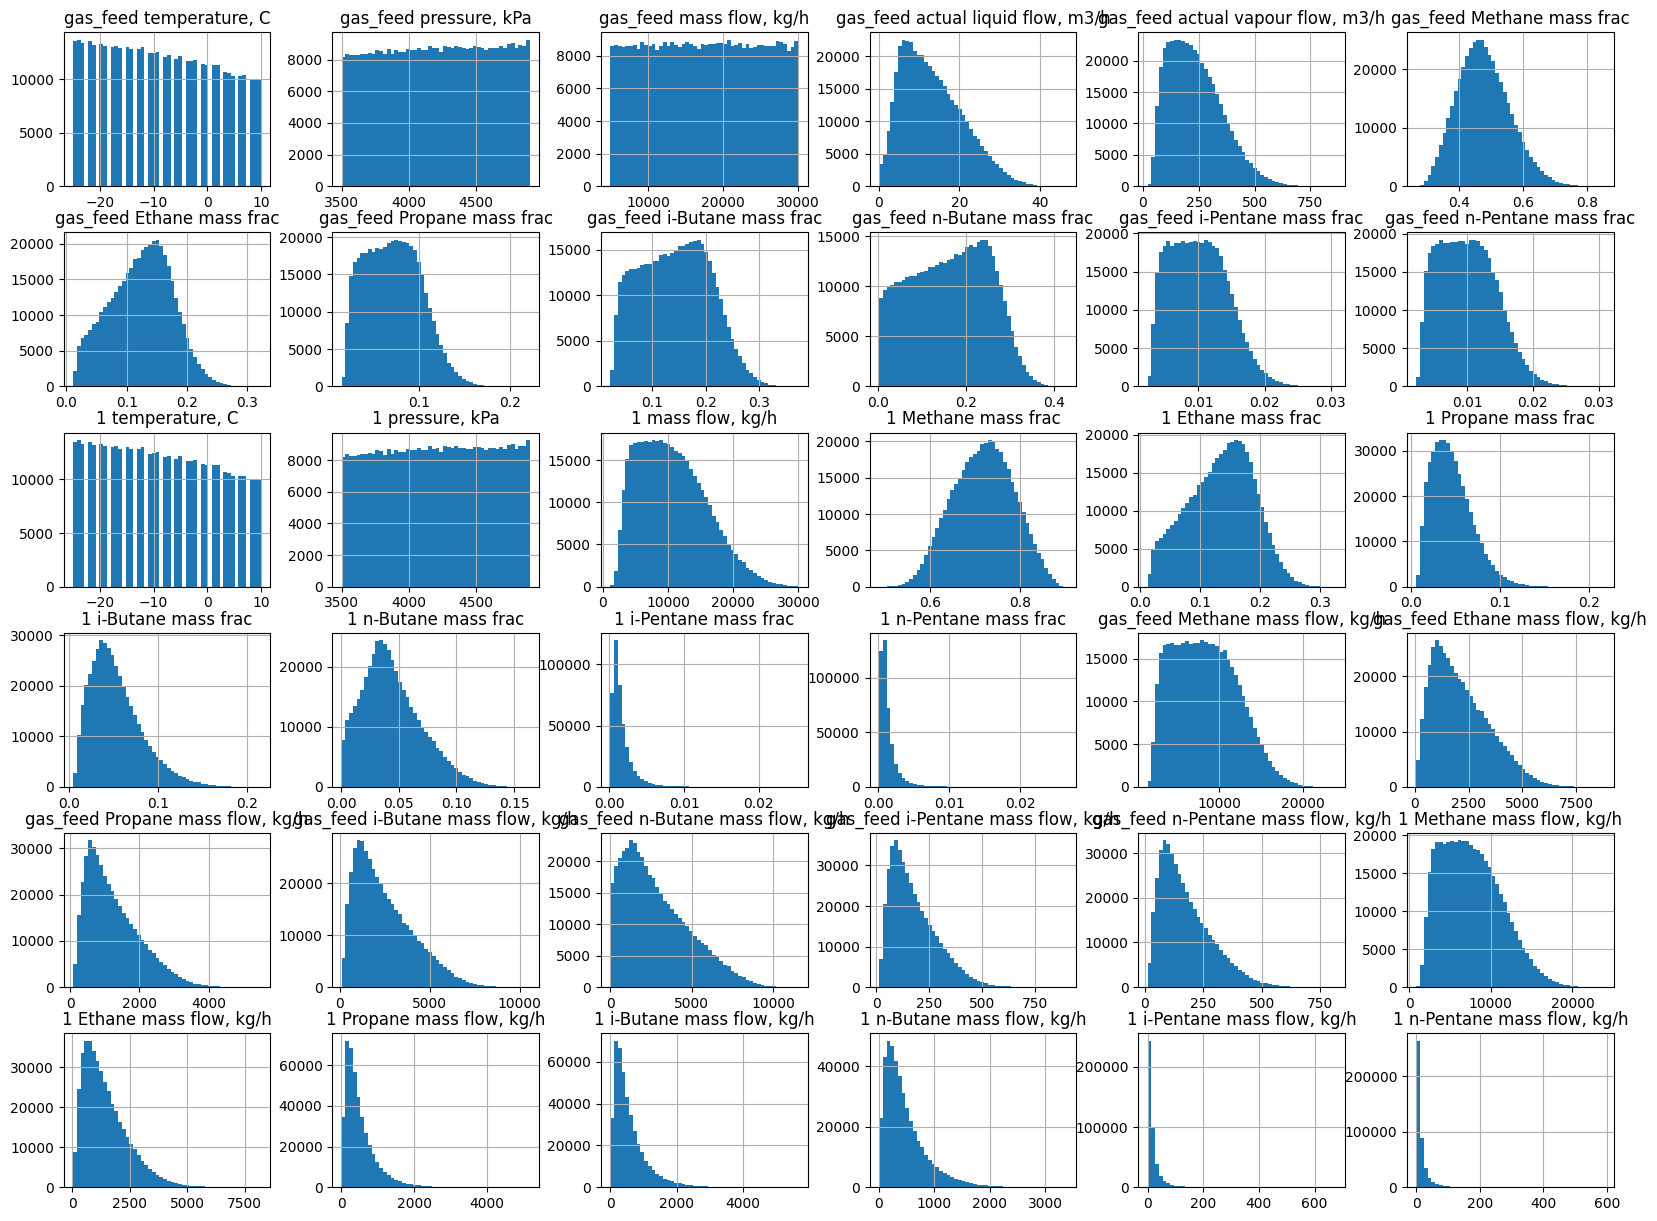

In [64]:
sep_prod_comp_sample.hist(bins=50, figsize=(20, 15));

In [65]:
corr_matrix = sep_prod_comp_sample.corr()

corr_matrix['1 Methane mass flow, kg/h'].sort_values(ascending=False)

1 Methane mass flow, kg/h             1.000000
gas_feed Methane mass flow, kg/h      0.992619
1 mass flow, kg/h                     0.975585
gas_feed actual vapour flow, m3/h     0.945433
gas_feed mass flow, kg/h              0.868473
1 Propane mass flow, kg/h             0.658852
gas_feed i-Pentane mass flow, kg/h    0.635723
gas_feed n-Pentane mass flow, kg/h    0.633460
1 Ethane mass flow, kg/h              0.620593
1 i-Butane mass flow, kg/h            0.597547
gas_feed Propane mass flow, kg/h      0.574975
gas_feed Ethane mass flow, kg/h       0.534283
1 i-Pentane mass flow, kg/h           0.518604
1 n-Butane mass flow, kg/h            0.502374
1 n-Pentane mass flow, kg/h           0.487269
gas_feed Methane mass frac            0.450700
gas_feed i-Butane mass flow, kg/h     0.436268
gas_feed actual liquid flow, m3/h     0.313517
gas_feed n-Butane mass flow, kg/h     0.265492
1 i-Pentane mass frac                 0.238849
1 n-Pentane mass frac                 0.233796
1 Propane mas

In [66]:
list(sep_prod_comp_sample.columns)

['gas_feed temperature, C',
 'gas_feed pressure, kPa',
 'gas_feed mass flow, kg/h',
 'gas_feed actual liquid flow, m3/h',
 'gas_feed actual vapour flow, m3/h',
 'gas_feed Methane mass frac',
 'gas_feed Ethane mass frac',
 'gas_feed Propane mass frac',
 'gas_feed i-Butane mass frac',
 'gas_feed n-Butane mass frac',
 'gas_feed i-Pentane mass frac',
 'gas_feed n-Pentane mass frac',
 '1 temperature, C',
 '1 pressure, kPa',
 '1 mass flow, kg/h',
 '1 Methane mass frac',
 '1 Ethane mass frac',
 '1 Propane mass frac',
 '1 i-Butane mass frac',
 '1 n-Butane mass frac',
 '1 i-Pentane mass frac',
 '1 n-Pentane mass frac',
 'gas_feed Methane mass flow, kg/h',
 'gas_feed Ethane mass flow, kg/h',
 'gas_feed Propane mass flow, kg/h',
 'gas_feed i-Butane mass flow, kg/h',
 'gas_feed n-Butane mass flow, kg/h',
 'gas_feed i-Pentane mass flow, kg/h',
 'gas_feed n-Pentane mass flow, kg/h',
 '1 Methane mass flow, kg/h',
 '1 Ethane mass flow, kg/h',
 '1 Propane mass flow, kg/h',
 '1 i-Butane mass flow, kg/h'

In [67]:
## Тестовая и обучающая выборки
X = sep_prod_comp_sample[[
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
]]

y = sep_prod_comp_sample[[
    '1 Methane mass flow, kg/h', '1 Ethane mass flow, kg/h', '1 Propane mass flow, kg/h', '1 i-Butane mass flow, kg/h',
    '1 n-Butane mass flow, kg/h', '1 i-Pentane mass flow, kg/h', '1 n-Pentane mass flow, kg/h'
]]

# Собираем трансформер столбцов
ct = make_column_transformer(
    (MinMaxScaler(), [
    'gas_feed temperature, C', 'gas_feed pressure, kPa', 'gas_feed mass flow, kg/h', 'gas_feed actual liquid flow, m3/h',
    'gas_feed actual vapour flow, m3/h', 'gas_feed Methane mass frac', 'gas_feed Ethane mass frac',
    'gas_feed Propane mass frac', 'gas_feed i-Butane mass frac', 'gas_feed n-Butane mass frac',
    'gas_feed i-Pentane mass frac', 'gas_feed n-Pentane mass frac', 'gas_feed Methane mass flow, kg/h',
    'gas_feed Ethane mass flow, kg/h', 'gas_feed Propane mass flow, kg/h', 'gas_feed i-Butane mass flow, kg/h',
    'gas_feed n-Butane mass flow, kg/h', 'gas_feed i-Pentane mass flow, kg/h', 'gas_feed n-Pentane mass flow, kg/h',
    '1 temperature, C', '1 pressure, kPa', '1 mass flow, kg/h',
                     ])
)

# Создаем обучающую и тестовые выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Загружаем тренировочную выборку
ct.fit(X_train)

# Нормализуем данные
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

X_train_normal.shape, y_train.shape

((346052, 22), (346052, 7))

In [68]:
# Set random set
tf.random.set_seed(42)

# 1. Create a model
sep_top_prod_comp_model = tf.keras.Sequential([
    tf.keras.layers.Dense(22, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(7)
])

# 2. Compile the model
sep_top_prod_comp_model.compile(
    loss='mae',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['mae']
)

# 3. Fit the model
sep_top_prod_comp_model.fit(X_train_normal, y_train, epochs=100)

Epoch 1/100
10815/10815 [==============================] - 19s 2ms/step - loss: 175.5137 - mae: 175.5137
Epoch 2/100
10815/10815 [==============================] - 24s 2ms/step - loss: 93.9676 - mae: 93.9676
Epoch 3/100
10815/10815 [==============================] - 25s 2ms/step - loss: 60.1299 - mae: 60.1299
Epoch 4/100
10815/10815 [==============================] - 25s 2ms/step - loss: 20.5463 - mae: 20.5463
Epoch 5/100
10815/10815 [==============================] - 29s 3ms/step - loss: 16.5661 - mae: 16.5661
Epoch 6/100
10815/10815 [==============================] - 26s 2ms/step - loss: 15.2476 - mae: 15.2476
Epoch 7/100
10815/10815 [==============================] - 25s 2ms/step - loss: 14.0616 - mae: 14.0616
Epoch 8/100
10815/10815 [==============================] - 25s 2ms/step - loss: 13.0947 - mae: 13.0947
Epoch 9/100
10815/10815 [==============================] - 25s 2ms/step - loss: 12.4752 - mae: 12.4752
Epoch 10/100
10815/10815 [==============================] - 25s 2ms/ste

10815/10815 [==============================] - 27s 3ms/step - loss: 4.5903 - mae: 4.5903
Epoch 82/100
10815/10815 [==============================] - 26s 2ms/step - loss: 4.6344 - mae: 4.6344
Epoch 83/100
10815/10815 [==============================] - 26s 2ms/step - loss: 4.5294 - mae: 4.5294
Epoch 84/100
10815/10815 [==============================] - 26s 2ms/step - loss: 4.5226 - mae: 4.5226
Epoch 85/100
10815/10815 [==============================] - 25s 2ms/step - loss: 4.5163 - mae: 4.5163
Epoch 86/100
10815/10815 [==============================] - 25s 2ms/step - loss: 4.4960 - mae: 4.4960
Epoch 87/100
10815/10815 [==============================] - 24s 2ms/step - loss: 4.4732 - mae: 4.4732
Epoch 88/100
10815/10815 [==============================] - 25s 2ms/step - loss: 4.4746 - mae: 4.4746
Epoch 89/100
10815/10815 [==============================] - 24s 2ms/step - loss: 4.4464 - mae: 4.4464
Epoch 90/100
10815/10815 [==============================] - 25s 2ms/step - loss: 4.4215 - mae: 

In [69]:
y_pred = sep_top_prod_comp_model.predict(X_test_normal)

2704/2704 [==============================] - 3s 1ms/step


In [119]:
x = 8767
pred = y_pred[x]
list(pred)

[5872.605, 953.3933, 612.34766, 276.93967, 90.81008, 19.044065, 17.482021]

In [120]:
test = y_test.iloc[x]
test

1 Methane mass flow, kg/h      5858.465612
1 Ethane mass flow, kg/h        957.254716
1 Propane mass flow, kg/h       615.773281
1 i-Butane mass flow, kg/h      277.395560
1 n-Butane mass flow, kg/h       86.675143
1 i-Pentane mass flow, kg/h      17.512512
1 n-Pentane mass flow, kg/h      14.482297
Name: 446345, dtype: float64

In [121]:
sum(list(test.values))

7827.559121791195

In [122]:
sum(list(pred))

7842.621782302856

In [123]:
sum(list(test.values)) - sum(list(pred))

-15.062660511661306

In [124]:
list(list(pred) / sum(list(pred)))

[0.74880636,
 0.12156564,
 0.07807946,
 0.03531213,
 0.011579047,
 0.002428278,
 0.0022291043]

In [125]:
list(list(test.values) / sum(list(test.values)))

[0.748440927844898,
 0.12229287585796172,
 0.07866734336654861,
 0.0354383219265885,
 0.011073074190694202,
 0.0022372890692744004,
 0.0018501677440345002]

In [126]:
sep_top_prod_comp_model.save('./models/low_temp_dist_24_04/sep_top_prod_comp_model.h5')